# Part 3.3: Radiation Dataset

In this notebook, we will add the daily mean radiation information per subbasin.

#### Datasets

I used E-OBS dataset here and acknowledge the E-OBS dataset and the data providers in the ECA&D project
(https://www.ecad.eu). Cornes, R., G. van der Schrier, E.J.M. van den Besselaar, and P.D. Jones. 2018: An Ensemble
Version of the E-OBS Temperature and Precipitation Datasets, J. Geophys. Res. Atmos., 123.
doi:10.1029/2017JD028200

- Link to datasets (labeled HU): https://surfobs.climate.copernicus.eu/dataaccess/access_eobs_chunks.php


## Basin and subbasin information

We have finalized these geographic boundaries in ML2. We read-in what we saved as a result of that study.

In [1]:
# Read-in the water level dataset and check the content
%matplotlib inline

import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
INF_str = "/Users/oncel/Documents/Projects/KoelnPegelML/data/"
# Read-in the netCDF file
INFILE_base = "/Users/oncel/Documents/Projects/KoelnPegelML/data/"

In [2]:
import geopandas as gpd
cologne_catchment = gpd.read_file("Cologne_upstream_catchment.shp")
print(cologne_catchment.head())

    NEXT_SINK    HYBAS_ID   NEXT_DOWN    MAIN_BAS  DIST_SINK  DIST_MAIN  \
0  2080023010  2080399810  2080392830  2080023010      300.6      300.6   
1  2080103570  2080103570  2080472700  2080023010        0.0      788.7   
2  2080109860  2080109860  2080411370  2080023010        0.0      381.2   

   SUB_AREA   UP_AREA   PFAF_ID  ENDO  COAST  ORDER   SORT  \
0    2002.1  145502.9  23261070     0      0      1   6337   
1      36.0      36.0  23267090     2      0      2  25285   
2      10.9      10.9  23261090     2      0      2  25313   

                                            geometry  
0  POLYGON ((6.94804 46.5464, 6.93946 46.54527, 6...  
1  POLYGON ((6.9875 47.18333, 6.98399 47.18423, 6...  
2  POLYGON ((7.24167 50.40417, 7.24167 50.40833, ...  


In [3]:
cologne_subbasins = gpd.read_file("cologne_subbasins_lvl5.shp")
print(cologne_subbasins.head())

   HYBAS_ID_1  NEXT_DOWN_   NEXT_SINK  MAIN_BAS_1  DIST_SINK_  DIST_MAIN_  \
0  2050465610  2050477000  2050008490  2050008490      2372.5      2372.5   
1  2050023010           0  2050023010  2050023010         0.0         0.0   
2  2050023010           0  2050023010  2050023010         0.0         0.0   
3  2050420240  2050023010  2050023010  2050023010       447.8       447.8   
4  2050420340  2050023010  2050023010  2050023010       447.9       447.9   

   SUB_AREA_1  UP_AREA_1  PFAF_ID_1  ENDO_1  ...  DIST_SIN_1  DIST_MAI_1  \
0     50388.9    50388.9      22799       0  ...       300.6       300.6   
1     25335.7   163008.5      23261       0  ...       300.6       300.6   
2     25335.7   163008.5      23261       0  ...         0.0       381.2   
3     28101.2    28101.4      23262       0  ...       300.6       300.6   
4     11589.0   109585.3      23263       0  ...       300.6       300.6   

   SUB_AREA_2  UP_AREA_2  PFAF_ID_2  ENDO_2  COAST_2  ORDER_2  SORT_2  \
0      

In [4]:
# Cologne coordinates
cologne_point = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy([6.96], [50.94]),  # lon, lat
    crs=cologne_catchment.crs
)

## Radiation in the Catchment Area

In [5]:
# Read-in precipitation dataset
INFILE_rr1 = "/Users/oncel/Documents/Projects/KoelnPegelML/data/qq_ens_mean_0.1deg_reg_1995-2010_v31.0e.nc"
INFILE_rr2 = "/Users/oncel/Documents/Projects/KoelnPegelML/data/qq_ens_mean_0.1deg_reg_2011-2024_v31.0e.nc"

In [6]:
import xarray as xr
# Open the NetCDF file
ds1 = xr.open_dataset(INFILE_rr1) 
ds2 = xr.open_dataset(INFILE_rr2) 
ds = xr.concat([ds1, ds2], dim="time")
print(ds)

# Select variable
rr = ds["qq"]  # daily averaged relative humidity (mm/day)

print(rr)

# Select location
rr_point = rr.sel(latitude=50.94, longitude=6.96, method="nearest")

<xarray.Dataset> Size: 14GB
Dimensions:    (time: 10958, latitude: 460, longitude: 700)
Coordinates:
  * time       (time) datetime64[ns] 88kB 1995-01-01 1995-01-02 ... 2024-12-31
  * longitude  (longitude) float64 6kB -24.95 -24.85 -24.75 ... 44.85 44.95
  * latitude   (latitude) float64 4kB 25.05 25.15 25.25 ... 70.75 70.85 70.95
Data variables:
    qq         (time, latitude, longitude) float32 14GB nan nan nan ... nan nan
Attributes:
    CDI:            Climate Data Interface version 2.4.4 (https://mpimet.mpg....
    Conventions:    CF-1.6
    E-OBS_version:  v31.0e
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Tue Jun 10 10:51:36 2025: cdo -O -z zip_3 seldate,1995010...
    CDO:            Climate Data Operators version 2.4.4 (https://mpimet.mpg....
<xarray.DataArray 'qq' (time: 10958, latitude: 460, longitude: 700)> Size: 14GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [n

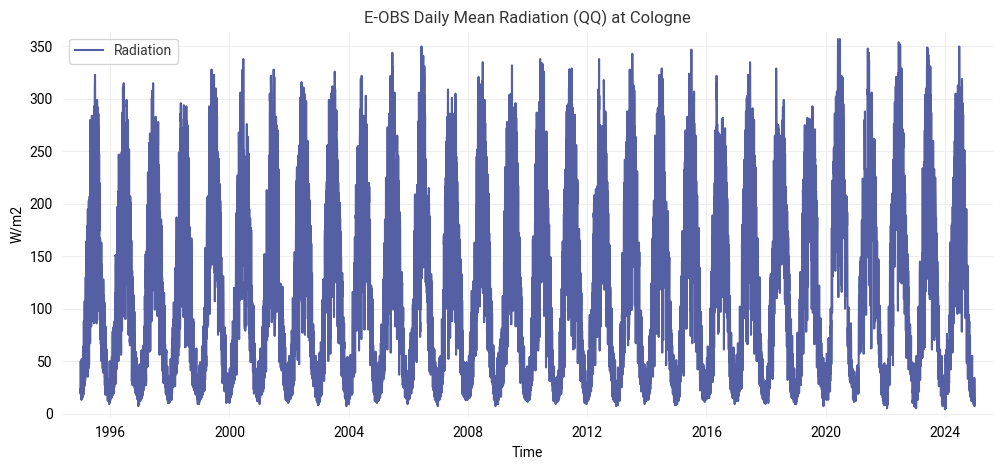

In [8]:
# --- 4. Plot time series ---
plt.figure(figsize=(12,5))
rr_point.plot(label="Radiation")
plt.title("E-OBS Daily Mean Radiation (QQ) at Cologne")
plt.xlabel("Time")
plt.ylabel("W/m2")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
print(rr.latitude.values[:5]) 

[25.04986065 25.14986065 25.24986065 25.34986065 25.44986065]


<xarray.DataArray 'qq' (time: 10958, latitude: 70, longitude: 85)> Size: 261MB
array([[[32., 32., 33., ..., nan, nan, nan],
        [31., 31., 30., ..., nan, nan, nan],
        [29., 29., 31., ..., 22., 21., nan],
        ...,
        [25., 25., 25., ..., 27., 27., 27.],
        [25., 24., 25., ..., 27., 27., 27.],
        [25., 24., 24., ..., 27., 27., 27.]],

       [[44., 44., 45., ..., nan, nan, nan],
        [44., 44., 44., ..., nan, nan, nan],
        [43., 43., 44., ..., 54., 54., nan],
        ...,
        [17., 17., 17., ..., 18., 18., 18.],
        [17., 17., 17., ..., 18., 18., 18.],
        [17., 16., 17., ..., 18., 18., 18.]],

       [[50., 50., 52., ..., nan, nan, nan],
        [51., 51., 51., ..., nan, nan, nan],
        [50., 51., 52., ..., 73., 72., nan],
        ...,
...
        [ 7.,  6.,  6., ..., 29., 29., 29.],
        [ 7.,  7.,  6., ..., 28., 28., 28.],
        [ 7.,  7.,  6., ..., 27., 27., 27.]],

       [[73., 73., 60., ..., nan, nan, nan],
        [60., 60.

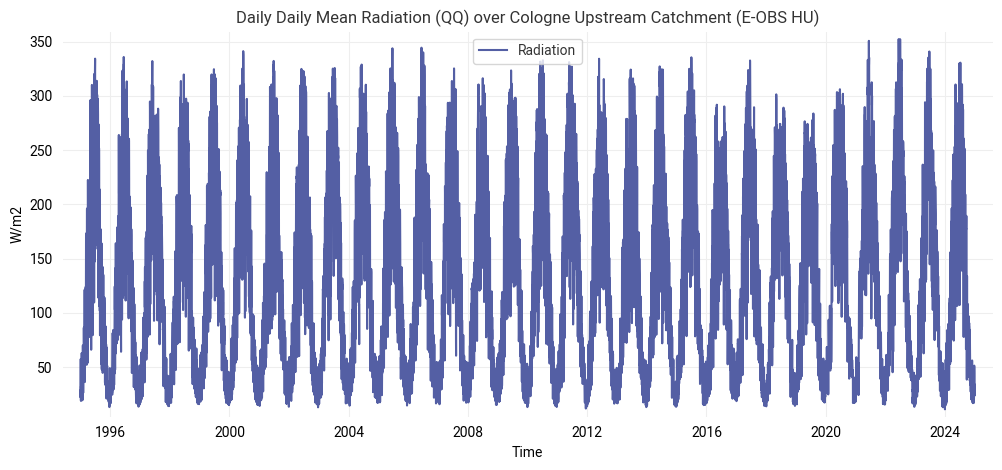

In [11]:
import regionmask
# Load upstream Cologne catchment
cologne_catchment = cologne_catchment.to_crs("EPSG:4326")  # ensure WGS84 lat/lon

# Clip grid to Rhine bounding box for speed
lon_min, lat_min, lon_max, lat_max = cologne_catchment.total_bounds
rr_subset = rr.sel(
    longitude=slice(lon_min-1, lon_max+1),
    latitude=slice(lat_min-1, lat_max+1)  # note: lat is usually decreasing in E-OBS
)
print(rr_subset)
# Create mask from catchment polygon
mask = regionmask.mask_geopandas(cologne_catchment, rr_subset.longitude, rr_subset.latitude)

# Find ID used by regionmask
catchment_id = int(cologne_catchment.index.values[0])
print("Catchment mask ID:", catchment_id)

# Apply mask
rr_cologne = rr_subset.where(mask == catchment_id).mean(dim=["longitude","latitude"])

# Plot
plt.figure(figsize=(12,5))
rr_cologne.plot(label="Radiation")

plt.title("Daily Daily Mean Radiation (QQ) over Cologne Upstream Catchment (E-OBS HU)")
plt.xlabel("Time")
plt.ylabel("W/m2")
plt.legend()
plt.grid(True)
plt.show()

Catchment ID: 0.0


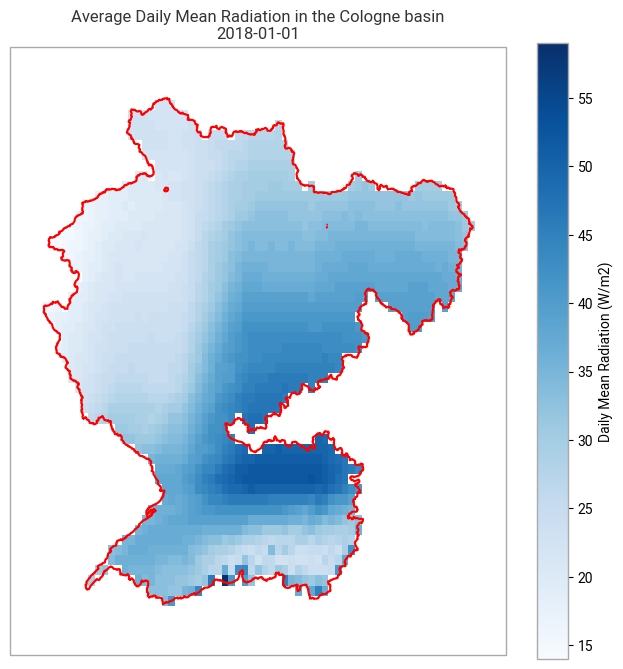

In [12]:
import numpy as np
# Cologne upstream basin
import cartopy.crs as ccrs
catchment_id = [v for v in np.unique(mask.values) if ~np.isnan(v)][0]
print("Catchment ID:", catchment_id)

rr_masked = rr.where(mask == catchment_id)

# Select one day of precipitation
day = "2018-01-01"
rr_day = rr_masked.sel(time=day)

# Plot only inside basin
fig, ax = plt.subplots(
    1, 1, figsize=(8, 8),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)

rr_day.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Blues",
    add_colorbar=True,
    cbar_kwargs=dict(label="Daily Mean Radiation (W/m2)")
)

# Basin outline
cologne_catchment.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)
minx, miny, maxx, maxy = cologne_catchment.total_bounds
ax.set_extent([minx - 0.5, maxx + 0.5, miny - 0.5, maxy + 0.5], crs=ccrs.PlateCarree())
plt.title(f"Average Daily Mean Radiation in the Cologne basin\n{day}")
plt.show()

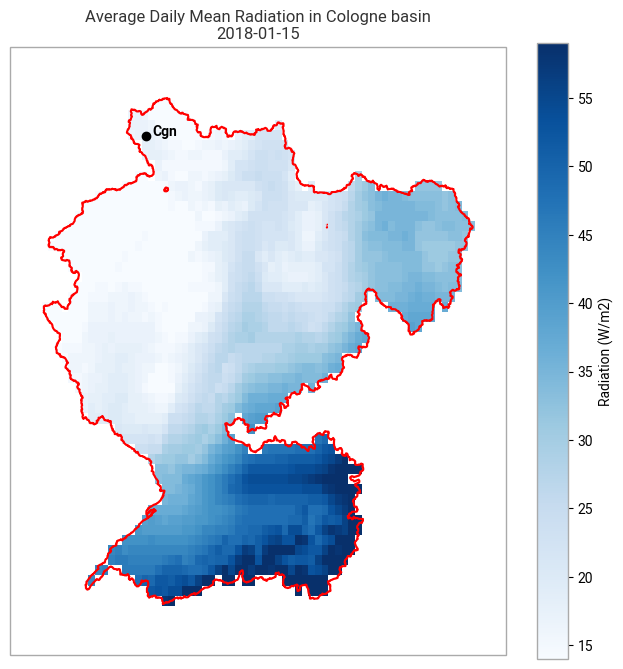

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs

# Select a 2-week time slice
start = "2018-01-01"
end   = "2018-01-15"
rr_period = rr_masked.sel(time=slice(start, end))

# Prepare figure
fig, ax = plt.subplots(
    1, 1, figsize=(8, 8),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)

# Plot first frame
rr_plot = rr_period.isel(time=0).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Blues",
    add_colorbar=True,
    cbar_kwargs=dict(label="Radiation (W/m2)")
)

# Cologne coordinates
cologne_lon, cologne_lat = 6.96, 50.94

# Add Cologne as a black point
ax.plot(cologne_lon, cologne_lat, marker="o", color="black",
        markersize=6, transform=ccrs.PlateCarree())

# Add label next to point
ax.text(cologne_lon + 0.1, cologne_lat, "Cgn", color="black",
        fontsize=10, weight="bold", transform=ccrs.PlateCarree())

# Basin outline
cologne_catchment.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)
minx, miny, maxx, maxy = cologne_catchment.total_bounds
ax.set_extent([minx - 0.5, maxx + 0.5, miny - 0.5, maxy + 0.5], crs=ccrs.PlateCarree())

# Title handle
title = ax.set_title(f"Average Daily Mean Radiation in Cologne basin\n{str(rr_period.time.values[0])[:10]}")

# Animation update function
def update(frame):
    data = rr_period.isel(time=frame)
    rr_plot.set_array(data.values.flatten())  # update values
    title.set_text(f"Average Daily Mean Radiation in Cologne basin\n{str(data.time.values)[:10]}")
    return rr_plot, title

# Build animation
anim = animation.FuncAnimation(
    fig, update, frames=len(rr_period.time),
    interval=500, blit=False
)

# Save to file (e.g. MP4 or GIF)
anim.save("outputvisuals/radiation_cologne_2weeks.gif", writer="pillow", fps=2)

plt.show()

## Subbasins

In [16]:
basins_lvl5_in_cologne = cologne_subbasins
# Subset RR data to bounding box for efficiency
lon_min, lat_min, lon_max, lat_max = basins_lvl5_in_cologne.total_bounds
rr_subset = rr.sel(
    longitude=slice(lon_min-1, lon_max+1),
    latitude=slice(lat_min-1, lat_max+1)
)

# Mask precipitation for each level-5 basin
mask = regionmask.mask_geopandas(basins_lvl5_in_cologne, rr_subset.longitude, rr_subset.latitude)
mask_3D = mask.broadcast_like(rr_subset)

# Stack lat/lon into one dimension
rr_stacked = rr_subset.stack(points=("latitude", "longitude"))

# Align mask with same stacked points
mask_stacked = mask.stack(points=("latitude", "longitude"))

# Group precipitation by sub-basin IDs
rr_subbasins = rr_stacked.groupby(mask_stacked).mean("points")
print(rr_subbasins)


<xarray.DataArray 'qq' (time: 10958, mask: 9)> Size: 394kB
array([[21.049019, 26.727795, 23.054794, ..., 30.946428, 27.31884 ,
        28.342245],
       [17.960785, 19.16619 , 16.924658, ..., 21.125   , 34.115944,
        33.786095],
       [20.264706, 22.34957 , 19.19178 , ..., 22.958334, 47.9372  ,
        38.251335],
       ...,
       [15.215686, 14.879656, 16.08904 , ..., 30.708334, 44.830917,
        53.673798],
       [11.509804, 14.38682 , 13.890411, ..., 24.494047, 43.449276,
        44.213905],
       [18.745098, 21.830946, 19.945206, ..., 39.22619 , 52.63768 ,
        55.828876]], shape=(10958, 9), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 88kB 1995-01-01 1995-01-02 ... 2024-12-31
  * mask     (mask) float64 72B 1.0 3.0 4.0 5.0 6.0 7.0 9.0 10.0 11.0
Attributes:
    standard_name:  surface_downwelling_shortwave_flux_in_air
    long_name:      surface downwelling shortwave flux in air
    units:          W/m2


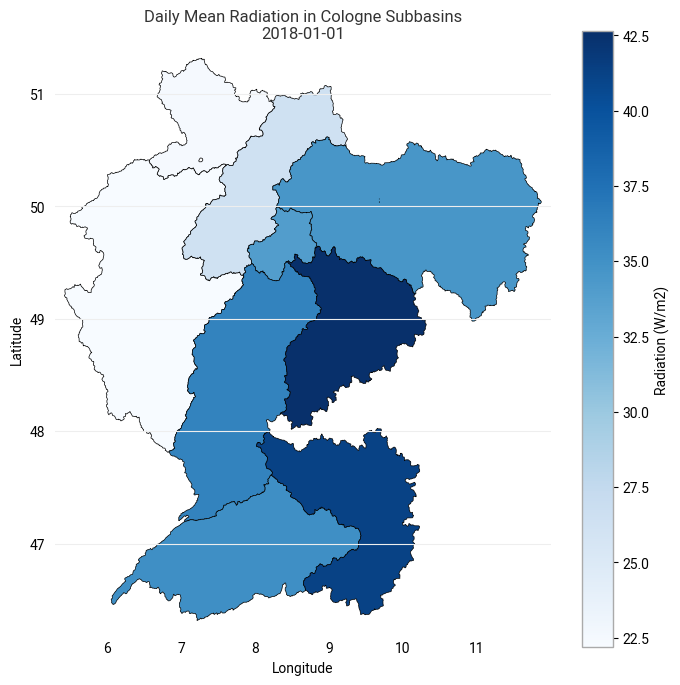

In [19]:
# Date
day = "2018-01-01"
precip_day = rr_subbasins.sel(time=day).to_pandas()

# put into DataFrame: index=subbasin id, value=precip
df_day = precip_day.reset_index()
df_day.columns = ["subbasin_id", "rad"]

# merge with GeoDataFrame
basins_with_precip = basins_lvl5_in_cologne.copy()
basins_with_precip["rad"] = basins_with_precip.index.map(df_day.set_index("subbasin_id")["rad"])

# plot
fig, ax = plt.subplots(figsize=(8,8))
basins_with_precip.plot(
    ax=ax, 
    column="rad", 
    cmap="Blues", 
    legend=True, 
    edgecolor="black", 
    linewidth=0.5,
    legend_kwds={"label": "Radiation (W/m2)"}
)

plt.title(f"Daily Mean Radiation in Cologne Subbasins\n{day}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Creating training dataset

            sbs_rad_1  sbs_rad_3  sbs_rad_4  sbs_rad_5  sbs_rad_6  sbs_rad_7  \
time                                                                           
1995-01-01  21.049019  26.727795  23.054794  30.838984  29.571428  30.611111   
1995-01-02  17.960785  19.166189  16.924658  16.319208  16.885714  22.000000   
1995-01-03  20.264706  22.349569  19.191780  20.338984  19.571428  29.666666   
1995-01-04  46.019608  54.736389  46.589043  43.562145  47.942856  56.936508   
1995-01-05  51.098038  58.429798  52.061646  50.974575  53.114285  58.507938   

            sbs_rad_9  sbs_rad_10  sbs_rad_11  
time                                           
1995-01-01  30.946428   27.318840   28.342245  
1995-01-02  21.125000   34.115944   33.786095  
1995-01-03  22.958334   47.937199   38.251335  
1995-01-04  50.285713   59.101448   55.684490  
1995-01-05  54.500000   69.859901   63.320854  


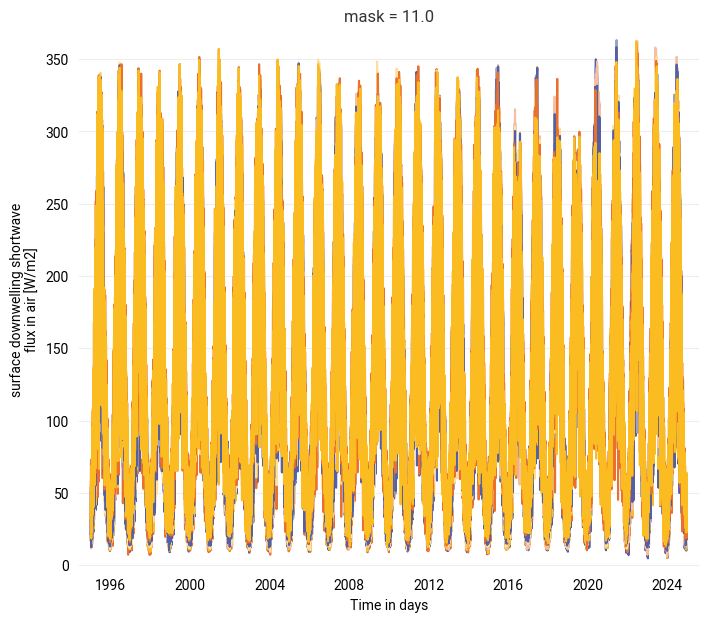

In [20]:
# Convert to wide format: time index, subbasins as columns
df_precip_subbasins = rr_subbasins.to_pandas()

# Rename columns for readability
df_precip_subbasins.columns = [f"sbs_rad_{int(c)}" for c in df_precip_subbasins.columns]

print(df_precip_subbasins.head())

for basin_id in rr_subbasins["mask"].values:
    if np.isnan(basin_id):  # skip outside pixels
        continue
    rr_subbasins.sel(mask=basin_id).plot(label=f"Subbasin {int(basin_id)}")



In [21]:
# Check the df
df_precip_subbasins

,sbs_rad_1,sbs_rad_3,sbs_rad_4,sbs_rad_5,sbs_rad_6,sbs_rad_7,sbs_rad_9,sbs_rad_10,sbs_rad_11
time,,,,,,,,,
1995-01-01,21.049019,26.727795,23.054794,30.838984,29.571428,30.611111,30.946428,27.318840,28.342245
1995-01-02,17.960785,19.166189,16.924658,16.319208,16.885714,22.000000,21.125000,34.115944,33.786095
1995-01-03,20.264706,22.349569,19.191780,20.338984,19.571428,29.666666,22.958334,47.937199,38.251335
1995-01-04,46.019608,54.736389,46.589043,43.562145,47.942856,56.936508,50.285713,59.101448,55.684490
1995-01-05,51.098038,58.429798,52.061646,50.974575,53.114285,58.507938,54.500000,69.859901,63.320854
...,...,...,...,...,...,...,...,...,...
2024-12-27,38.803921,57.183380,45.047947,46.677967,47.571430,52.198414,50.440475,43.140095,47.786095
2024-12-28,37.549019,44.991405,39.061646,37.872883,33.914288,47.884922,47.279762,47.565216,53.962566
2024-12-29,15.215686,14.879656,16.089041,22.960451,16.457144,26.595238,30.708334,44.830917,53.673798


In [23]:
test1 = df_precip_subbasins[df_precip_subbasins["sbs_rad_1"] < 0]
test1

,sbs_rad_1,sbs_rad_3,sbs_rad_4,sbs_rad_5,sbs_rad_6,sbs_rad_7,sbs_rad_9,sbs_rad_10,sbs_rad_11
time,,,,,,,,,


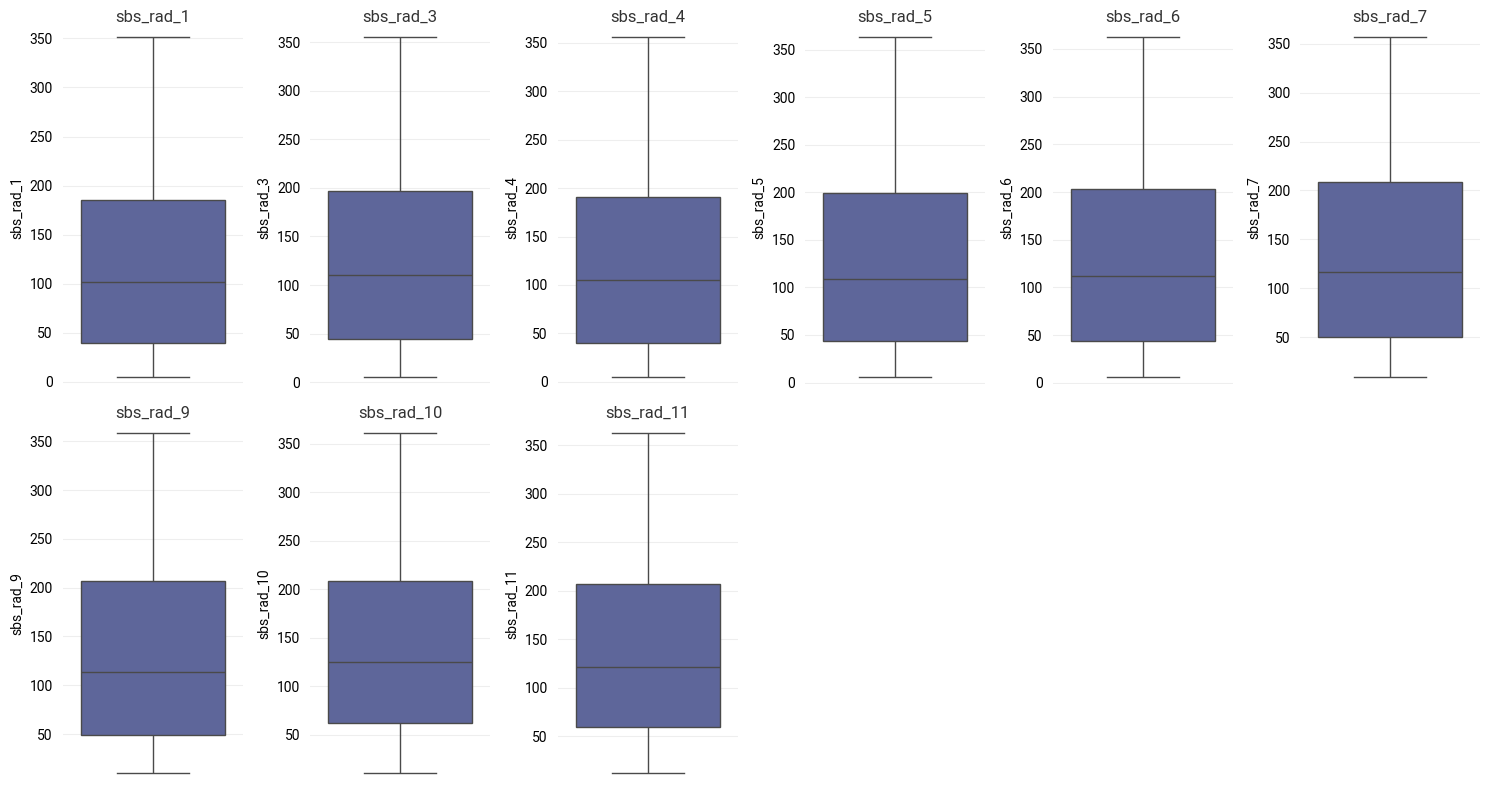

In [25]:
# Check the distributions
import math
import seaborn as sns
ncols = 6
nrows = math.ceil(len(df_precip_subbasins.columns) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows*4))

for ax, col in zip(axes.flat, df_precip_subbasins.columns):
    #sns.violinplot(y=df_precip_subbasins[col], ax=ax) goes to minimum although there is no minimum
    sns.boxplot(y=df_precip_subbasins[col], ax=ax)
    ax.set_title(col)
    #ax.set_yscale("log")                 # log scale
    #ax.set_ylim(0,100)              # fixed limits across all plots

# Hide empty subplots
for ax in axes.flat[len(df_precip_subbasins.columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## Creating training dataset

In [26]:
# Create dataset
df_precip_subbasins.to_csv("training_datasets/train_rad_preprocessed.csv", index=True)  # keep index if it's meaningful
print(df_precip_subbasins)

            sbs_rad_1  sbs_rad_3  sbs_rad_4  sbs_rad_5  sbs_rad_6  sbs_rad_7  \
time                                                                           
1995-01-01  21.049019  26.727795  23.054794  30.838984  29.571428  30.611111   
1995-01-02  17.960785  19.166189  16.924658  16.319208  16.885714  22.000000   
1995-01-03  20.264706  22.349569  19.191780  20.338984  19.571428  29.666666   
1995-01-04  46.019608  54.736389  46.589043  43.562145  47.942856  56.936508   
1995-01-05  51.098038  58.429798  52.061646  50.974575  53.114285  58.507938   
...               ...        ...        ...        ...        ...        ...   
2024-12-27  38.803921  57.183380  45.047947  46.677967  47.571430  52.198414   
2024-12-28  37.549019  44.991405  39.061646  37.872883  33.914288  47.884922   
2024-12-29  15.215686  14.879656  16.089041  22.960451  16.457144  26.595238   
2024-12-30  11.509804  14.386820  13.890411  19.483051  12.857142  21.884920   
2024-12-31  18.745098  21.830946  19.945